## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`



The label file can be loaded as a usual CSV file.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
labels = pd.read_csv('/datasets/faces/labels.csv')

print(labels.sample(5))
print(labels.info())
print(labels.describe())


       file_name  real_age
3719  003719.jpg        13
681   000681.jpg        28
4426  004426.jpg        32
5100  005100.jpg         4
7152  007168.jpg        46
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


## EDA

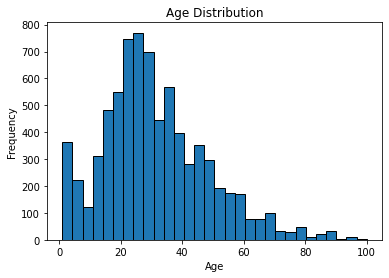

In [15]:
plt.hist(labels['real_age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [16]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

Found 7591 validated image filenames.


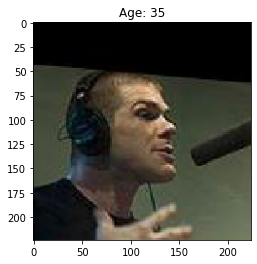

In [17]:
x, y = next(generator)
plt.imshow(x[0])
plt.title(f'Age: {y[0]}')
plt.show()

In [18]:
duplicates = labels.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Q1 = labels['real_age'].quantile(0.25)
Q3 = labels['real_age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = labels[(labels['real_age'] < lower_bound) | (labels['real_age'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

Number of duplicate rows: 0
Number of outliers: 169


In [19]:
outliers = labels[(labels['real_age'] < lower_bound) | (labels['real_age'] > upper_bound)]
print(outliers)


       file_name  real_age
2     000002.jpg        80
115   000115.jpg        80
167   000167.jpg        80
255   000255.jpg        80
533   000533.jpg        80
...          ...       ...
7423  007445.jpg        86
7425  007447.jpg        74
7504  007526.jpg        90
7523  007545.jpg        75
7554  007576.jpg        78

[169 rows x 2 columns]


### Findings

I have loaded and analyzed the data for this project. There do not seem to be any missing values or obvious duplicates, so on that front the data seems perfectly alright. I prepared an image data generator in order to help preprocess the data later on. The outliers appear to be made up of a lot of older people, which should not impact the model, especially as there are only 169 outliers that I found. We have enough data points to likely make up for these if they do cause a problem. One concern I have is that there aren't as many datapoints for teenagers as there are for younger children and for ages 20-40. I will keep this in mind if problems arise later if this imbalance need be addressed. 

## Modelling

In [20]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [21]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw'
    )
    return train_gen_flow

In [22]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw'
    )
    return test_gen_flow

In [23]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', 
                  metrics=['mae'])
    return model

In [24]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Prepare the Script to Run on the GPU Platform

In [ ]:


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [28]:
init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


np.random.seed(42)
tf.random.set_seed(42)

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training'
    )
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', 
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=3)
    return model

path = '/datasets/faces/'

train_data = load_train(path)
test_data = load_test(path)

input_shape = (224, 224, 3)

model = create_model(input_shape)

model = train_model(model, train_data, test_data)


"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)



### Output

## Conclusions